# Housekeeping

In [1]:
# SPARK SETUP
import findspark
findspark.init()

import pyspark 
from pyspark.sql import SparkSession

# later on - probably add dtypes in load phase
from pyspark.sql.types import StringType, IntegerType,\
    DoubleType, StructType, StructField, DateType

sc = pyspark.SparkContext()
conf = pyspark.SparkConf().setAll([('spark.executor.memory', '15g'), ('spark.executor.cores', '6'),
    ('spark.cores.max', '6'), ('spark.driver.memory','15g'), ("spark.kryoserializer.buffer.max","1g"),
    ("spark.sql.execution.arrow.pyspark.enabled", "true")])
sc.stop()
sc = pyspark.SparkContext(conf=conf)
ss = SparkSession.builder.getOrCreate()
# terminate # set parames # get or create
ss.sparkContext.setLogLevel("ERROR")
ss.sparkContext.getConf().getAll()    

22/04/28 16:08:52 WARN Utils: Your hostname, mf-H110M-S2H resolves to a loopback address: 127.0.1.1; using 192.168.0.108 instead (on interface enx00d2b176ce73)
22/04/28 16:08:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/28 16:08:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


[('spark.driver.memory', '15g'),
 ('spark.executor.id', 'driver'),
 ('spark.executor.memory', '15g'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.port', '43467'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.executor.cores', '6'),
 ('spark.kryoserializer.buffer.max', '1g'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '192.168.0.108'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.startTime', '1651154934536'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.sql.execution.arrow.pyspark.enabled', 'true'),
 ('spark.app.id', 'local-1651154934619'),
 ('spark.cores.max', '6')]

In [2]:
# load the data
DATA_IN = "../data/raw/rees46/"
categories = ss.read.csv(DATA_IN+"categories/",header=True, inferSchema=True, nanValue="null")
event_types = ss.read.csv(DATA_IN+"event_types/",header=True, inferSchema=True, nanValue="null")
events = ss.read.csv(DATA_IN+"events/",header=True, inferSchema=True, nanValue="null")
products = ss.read.csv(DATA_IN+"products/",header=True, inferSchema=True, nanValue="null")

In [3]:
def display_info(df):
    var_name = [name for name in globals() if globals()[name] is df]
    print("dataframe \"{}\" >\n".format(var_name[0]));
    print("shape ({}, {})\n".format(df.count(), len(categories.columns)));
    print("schema\n");
    df.printSchema();
    print("head\n");
    df.show(3);
# print info
display_info(categories)
display_info(event_types)
display_info(events)
display_info(products)

dataframe "categories" >

shape (1521, 2)

schema

root
 |-- category_id: double (nullable = true)
 |-- category_code: string (nullable = true)

head

+-----------+--------------------+
|category_id|       category_code|
+-----------+--------------------+
|      108.0|appliances.kitche...|
|      132.0|furniture.living_...|
|      748.0|       apparel.glove|
+-----------+--------------------+
only showing top 3 rows

dataframe "event_types" >

shape (3, 2)

schema

root
 |-- event_type_id: double (nullable = true)
 |-- event_type_name: string (nullable = true)

head

+-------------+---------------+
|event_type_id|event_type_name|
+-------------+---------------+
|          2.0|       purchase|
|          1.0|           cart|
|          0.0|           view|
+-------------+---------------+

dataframe "events" >



shape (27302818, 2)

schema

root
 |-- event_time: timestamp (nullable = true)
 |-- user_id: double (nullable = true)
 |-- product_id: double (nullable = true)
 |-- event_type_id: double (nullable = true)
 |-- price: double (nullable = true)
 |-- user_session: string (nullable = true)

head

+-------------------+-------+----------+-------------+------+--------------------+
|         event_time|user_id|product_id|event_type_id| price|        user_session|
+-------------------+-------+----------+-------------+------+--------------------+
|2019-12-01 13:38:37|  456.0|    1852.0|          0.0|196.43|59275569-cb2d-443...|
|2019-12-01 13:38:57|  456.0|    1852.0|          0.0|196.43|59275569-cb2d-443...|
|2019-12-01 13:45:30|  456.0|   19322.0|          0.0| 45.05|59275569-cb2d-443...|
+-------------------+-------+----------+-------------+------+--------------------+
only showing top 3 rows

dataframe "products" >

shape (428151, 2)

schema

root
 |-- product_id: double (nullable = true)
 |-

In [4]:
# rectify id dtypes and and persist the events
from pyspark.sql.functions import col
from pyspark.storagelevel import StorageLevel as sl
categories = categories.withColumn("category_id", col("category_id").cast("int"))
event_types = event_types.withColumn("event_type_id", col("event_type_id").cast("int"))
events = events.withColumn("user_id", col("user_id").cast("int"))\
    .withColumn("product_id", col("product_id").cast("int"))\
    .withColumn("event_type_id", col("event_type_id").cast("int"))
products = products.withColumn("product_id", col("product_id").cast("int"))\
    .withColumn("category_id", col("category_id").cast("int"))

# Preliminary exploration

In [34]:
# this might be cleaner with one-hots
import pyspark.sql.functions as f
events = events.withColumn("view", (col("event_type_id")==0).cast("int"))
events = events.withColumn("cart", (col("event_type_id")==1).cast("int"))
events = events.withColumn("purchase", (col("event_type_id")==2).cast("int"))
events = events.withColumn("revenue", col("purchase")*col("price")).persist(sl.DISK_ONLY)

In [35]:
# simple session agg
sessions = events.groupBy("user_session") \
    .agg(f.min("user_id").alias("user_id"), f.min("event_time").alias("session_start"), f.max("event_time").alias("session_end"),
        f.count("event_time").alias("click_counts"), f.sum("view").alias("view_counts"), f.sum("cart").alias("cart_counts"),
        f.sum("purchase").alias("purchase_counts"), f.sum("revenue").alias("revenue"))
sessions = sessions.withColumn("is_purchase", (col("revenue")>0).cast("int")).\
    withColumn("is_abadoned", ((col("is_purchase")==0) & (col("cart_counts")>0)).cast("int")).\
    withColumn("duration", ((col("session_end").cast("long")-col("session_start").cast("long"))/60).cast("double")).\
        persist(sl.DISK_ONLY)
sessions.show(3)    

+--------------------+-------+-------------------+-------------------+------------+-----------+-----------+---------------+-------+-----------+-----------+--------+
|        user_session|user_id|      session_start|        session_end|click_counts|view_counts|cart_counts|purchase_counts|revenue|is_purchase|is_abadoned|duration|
+--------------------+-------+-------------------+-------------------+------------+-----------+-----------+---------------+-------+-----------+-----------+--------+
|dedf266e-3da9-4c1...|    456|2020-04-22 17:42:18|2020-04-22 17:46:30|           5|          5|          0|              0|    0.0|          0|          0|     4.2|
|d7ede571-9fd3-4f9...|   5664|2019-12-27 11:40:02|2019-12-27 11:40:02|           1|          1|          0|              0|    0.0|          0|          0|     0.0|
|3793e5ba-666f-4ae...|   5664|2019-10-19 18:55:39|2019-10-19 18:55:39|           1|          1|          0|              0|    0.0|          0|          0|     0.0|
+---------

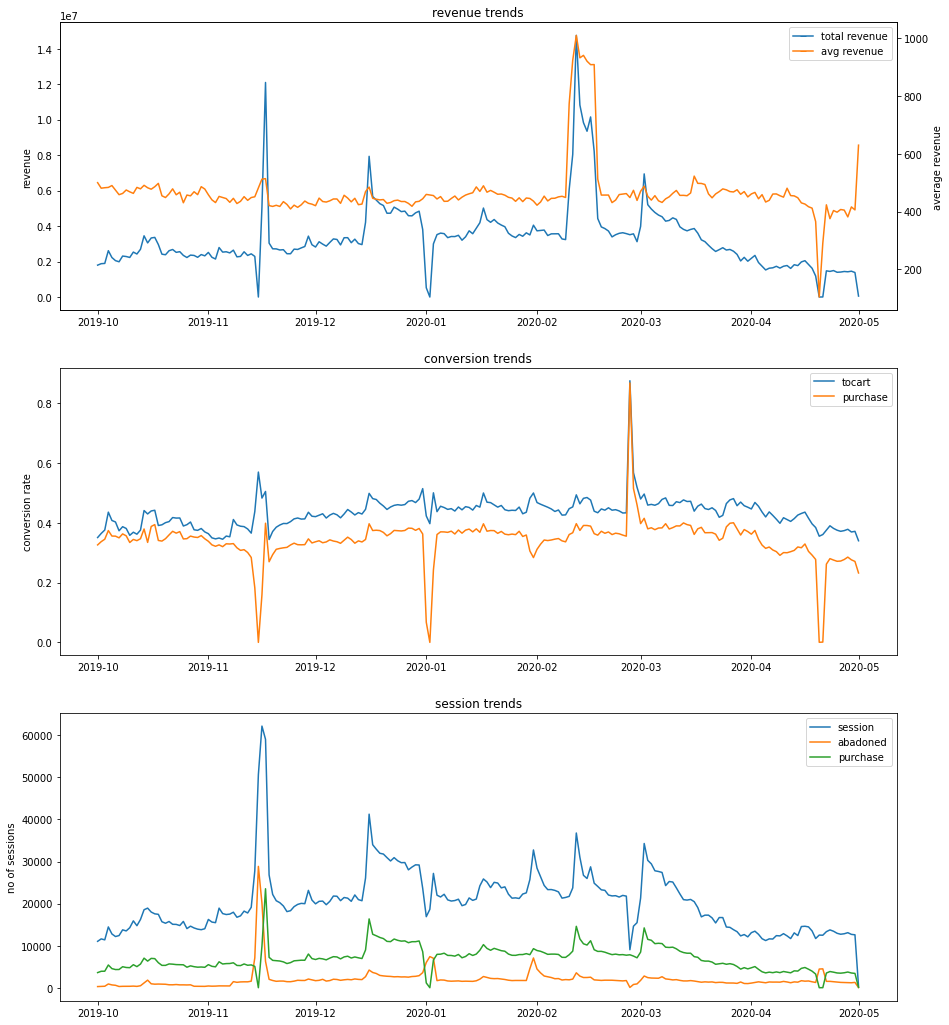

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# dynamic
## sessions/events
    ## revenue, no of sessions, avg transaction size
    ## no of sessions, abadoned sessions, transaction sessions
    ## conversion rates
    
# prepare sessions for ploting
session_plots = sessions.groupBy(f.to_date(sessions.session_start).alias("session_start")).agg(f.count("user_session").alias("session_count"),
    f.sum("is_abadoned").alias("abadoned_count"), f.sum("is_purchase").alias("purchase_count"), f.sum("revenue").alias("revenue"))
session_plots = session_plots.withColumn("left_count", col("session_count")-col("abadoned_count")-col("purchase_count")).\
    withColumn("avg_revenue", col("revenue")/col("purchase_count")).\
    withColumn("tocart_conversion", (col("abadoned_count")+col("purchase_count"))/col("session_count")).\
    withColumn("purchase_conversion", col("purchase_count")/col("session_count")).\
        toPandas()
session_plots.head(3)

# revenue trends
fig, ax = plt.subplots(3,1,figsize=(15,18))
from matplotlib.lines import Line2D
palt = sns.color_palette()
_ = sns.lineplot(x="session_start", y="revenue",
    data=session_plots, color=palt[0],ax=ax[0]);
tax =_.axes.twinx()
sns.lineplot(x="session_start", y="avg_revenue",
    data=session_plots, color=palt[1], ax=tax);
_.legend(handles=[Line2D([], [], marker="_", color=palt[0], label="total revenue"),
    Line2D([], [], marker="_", color=palt[1], label="avg revenue")])
ax[0].set_ylabel("revenue");
tax.set_ylabel("average revenue")
ax[0].set_xlabel("");
ax[0].set_title("revenue trends");

# session trends
melted = pd.melt(session_plots,"session_start",
    ["tocart_conversion", "purchase_conversion"])
melted["variable"] = melted["variable"].\
    apply(lambda x: x.split("_")[0])    

sns.lineplot(x="session_start", y="value",
    hue="variable", data=melted, ax=ax[1])
ax[1].set_ylabel("conversion rate");
ax[1].set_xlabel("");
ax[1].set_title("conversion trends");
ax[1].get_legend().set_title("");
del melted;

# conversion rate trends
melted = pd.melt(session_plots,"session_start",
    ["session_count", "abadoned_count", "purchase_count"])
melted["variable"] = melted["variable"].\
    apply(lambda x: x.split("_")[0])    

sns.lineplot(x="session_start", y="value",
    hue="variable", data=melted, ax=ax[2])
ax[2].set_ylabel("no of sessions");
ax[2].set_xlabel("");
ax[2].set_title("session trends");
ax[2].get_legend().set_title("");
del melted, session_plots;